# **Pioneer Assignment 1**

## **Part a**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# I load the pyramidal and brainstem data files into NumPy arrays
pyramidal = np.loadtxt("pyramidal_1.txt")
brainstem = np.loadtxt("brainstem.txt")

# I unpack each array into time, injected current, and recorded voltage
t_pyr, I_pyr, V_pyr = pyramidal[:,0], pyramidal[:,1], pyramidal[:,2]
t_brn, I_brn, V_brn = brainstem[:,0], brainstem[:,1], brainstem[:,2]

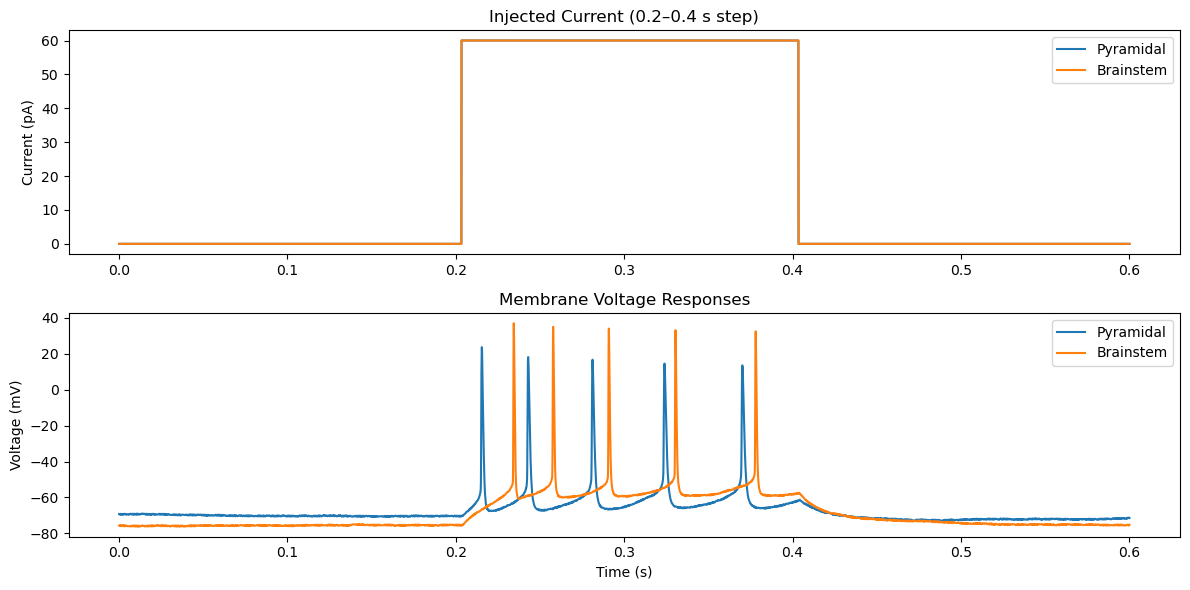

In [ ]:
plt.figure(figsize=(12, 6))

# I plot the current injection waveforms for both cells
plt.subplot(2, 1, 1)
plt.plot(t_pyr, I_pyr, label='Pyramidal Neuron')
plt.plot(t_brn, I_brn, label='Brainstem Neuron')
plt.ylabel('Current (pA)')
plt.title('Current Traces')
plt.legend()

# I plot the voltage responses side by side
plt.subplot(2, 1, 2)
plt.plot(t_pyr, V_pyr, label='Pyramidal Neuron')
plt.plot(t_brn, V_brn, label='Brainstem Neuron')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Traces')
plt.legend()

# Save the figure
plt.tight_layout()
plt.savefig("comparison_traces.jpg", dpi=300)
plt.show()

## **Part b**

In [ ]:
# I average the first 100 ms of each voltage trace
RMP_pyr = np.mean(V_pyr[0:1000])
RMP_brn = np.mean(V_brn[0:1000])

# Printing out the resting potentials I found
print(f"Resting Membrane Potential (Pyramidal Neuron): {RMP_pyr:.2f} mV")
print(f"Resting Membrane Potential (Brainstem Neuron): {RMP_brn:.2f} mV")

Resting Membrane Potential (Pyramidal Neuron): -69.81 mV
Resting Membrane Potential (Brainstem Neuron): -75.71 mV


## **Part c**

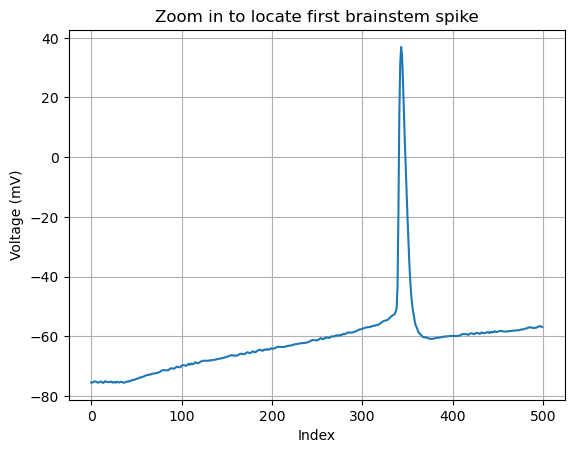

In [ ]:
# I quickly zoom in to visually locate the first spike in the brainstem trace
plt.plot(brainstem[2000:2500, 2])
plt.title("Zoom in to locate first brainstem spike")
plt.xlabel("Index")
plt.ylabel("Voltage (mV)")
plt.grid(True)
plt.show()

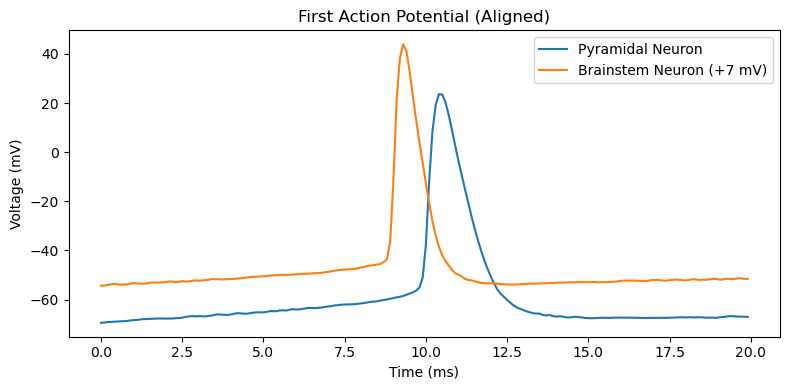

In [ ]:
# I slice out the exact 200-sample windows around index 2049–2249 and 2250–2450
spike_pyr    = V_pyr[2049:2249]    # 200 samples at 10 kHz → 20 ms
spike_brn    = V_brn[2250:2450]
spike_brn_sh = spike_brn + 7       # I shift it up by 7 mV for a fair overlay

# I build a time axis in milliseconds so the x-axis reads 0–20 ms
dt = 1/10000                       
n_pts = len(spike_pyr)             
time_ms = np.arange(n_pts) * dt * 1e3

# Finally, I plot both first spikes on the same axes for direct comparison
plt.figure(figsize=(8,4))
plt.plot(time_ms, spike_pyr,    label='Pyramidal Neuron')
plt.plot(time_ms, spike_brn_sh, label='Brainstem Neuron (+7 mV)')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("First Action Potential (Aligned)")
plt.legend()
plt.tight_layout()
plt.savefig("first_spike_overlay.jpg", dpi=300)
plt.show()

## **Part d**

In [ ]:
def analyze_spike(voltage, dt=0.0001): 
    """
    This function computes dV/dt to find the threshold (10 mV/ms crossing),
    then detects the peak, amplitude, afterhyperpolarization,
    and timing metrics for each spike.
    """

    dv_dt = np.diff(voltage) / dt  # instantaneous slope in mV/s

    # I find the first point where slope > 10 mV/ms
    threshold_index = np.argmax(dv_dt > 10000) 
    threshold_voltage = voltage[threshold_index]

    # Next, I locate the peak of the spike
    peak_index = np.argmax(voltage)
    peak_voltage = voltage[peak_index]

    # Amplitude relative to threshold
    amplitude = peak_voltage - threshold_voltage

    # Afterhyperpolarization
    ahp_index = peak_index + np.argmin(voltage[peak_index:])
    ahp_voltage = voltage[ahp_index]
    ahp_value = ahp_voltage - threshold_voltage

    # Timing: ms from threshold to peak and threshold to AHP
    ttp = abs(peak_index - threshold_index) * dt * 1000  

    # TTP-AHP = time from threshold to AHP
    ttp_ahp = abs(ahp_index - threshold_index) * dt * 1000  

    return {
        "threshold_index": threshold_index,
        "threshold_voltage": threshold_voltage,
        "peak_voltage": peak_voltage,
        "amplitude": amplitude,
        "ahp_voltage": ahp_voltage,
        "ahp_value": ahp_value,
        "ttp": ttp,
        "ttp_ahp": ttp_ahp
    }

In [ ]:
# I analyze both spikes and print the resulting feature dictionaries
features_pyr = analyze_spike(spike_pyr)
features_brn = analyze_spike(spike_brn)

print("Pyramidal Neuron Spike Features:")
for key, val in features_pyr.items():
    print(f"{key}: {val:.2f}")

print("\nBrainstem Neuron Spike Features:")
for key, val in features_brn.items():
    print(f"{key}: {val:.2f}")

Pyramidal Neuron Spike Features:
threshold_index: 97.00
threshold_voltage: -56.34
peak_voltage: 23.62
amplitude: 79.96
ahp_voltage: -67.60
ahp_value: -11.26
ttp: 0.70
ttp_ahp: 5.40

Brainstem Neuron Spike Features:
threshold_index: 87.00
threshold_voltage: -51.76
peak_voltage: 36.94
amplitude: 88.70
ahp_voltage: -60.88
ahp_value: -9.12
ttp: 0.60
ttp_ahp: 4.10


## **Part e**

pyramidal_1.txt: Current = 59.0 pA, Spikes = 5, Freq = 25.0 Hz
pyramidal_2.txt: Current = 78.6 pA, Spikes = 6, Freq = 30.0 Hz
pyramidal_3.txt: Current = 98.3 pA, Spikes = 8, Freq = 40.0 Hz
pyramidal_4.txt: Current = 118.0 pA, Spikes = 9, Freq = 45.0 Hz
pyramidal_5.txt: Current = 137.6 pA, Spikes = 9, Freq = 45.0 Hz


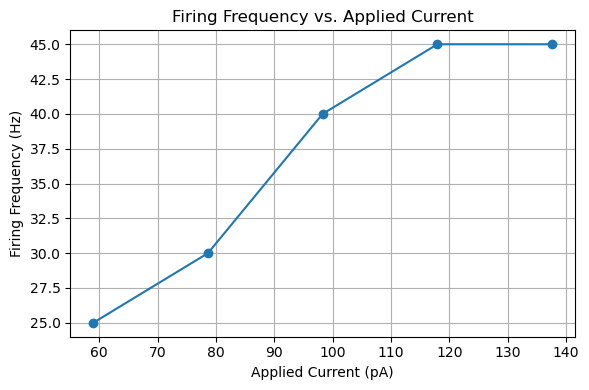

In [ ]:
def count_spikes(voltage, threshold=-30):
    """
    This function detects each positive-going crossing of the threshold
    to count individual spikes in a trace.
    """
    above_threshold = voltage > threshold
    spikes = np.diff(above_threshold.astype(int)) == 1
    return np.sum(spikes)

# I'll loop through the five pyramidal recordings
files = [
    "pyramidal_1.txt",
    "pyramidal_2.txt",
    "pyramidal_3.txt",
    "pyramidal_4.txt",
    "pyramidal_5.txt"
]

frequencies = []
currents = []

for file in files:
    try:
        data = np.loadtxt(file)
        time, current, voltage = data[:,0], data[:,1], data[:,2]

        # Get current amplitude
        stim_window = (time >= 0.2) & (time <= 0.4)
        I_applied = np.mean(current[stim_window])

        # Count spikes in that same window
        V_stim = voltage[stim_window]
        num_spikes = count_spikes(V_stim)

        freq = num_spikes / 0.2
        frequencies.append(freq)
        currents.append(I_applied)
        
        print(f"{file}: Current = {I_applied:.1f} pA, Spikes = {num_spikes}, Freq = {freq:.1f} Hz")
        
    except FileNotFoundError:
        print(f"Warning: Could not find {file}")
        continue

# Plot
if len(frequencies) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(currents, frequencies, marker='o')
    plt.xlabel("Applied Current (pA)")
    plt.ylabel("Firing Frequency (Hz)")
    plt.title("Firing Frequency vs. Applied Current")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("frequency_vs_current.jpg", dpi=300)
    plt.show()
else:
    print("No data to plot!")